In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pycountry
import pickle
import us

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 

from gensim.models import Word2Vec

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

%matplotlib inline

%config IPCompleter.greedy=True

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linhnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets_processed = pd.read_csv("tweets_processed.csv", parse_dates=["Created at"])

In [3]:
print("Since:",tweets_processed["Created at"].min())

# Print the maximum datetime
print("Until",tweets_processed["Created at"].max())

Since: 2021-03-23 12:51:23
Until 2021-03-31 00:33:10


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


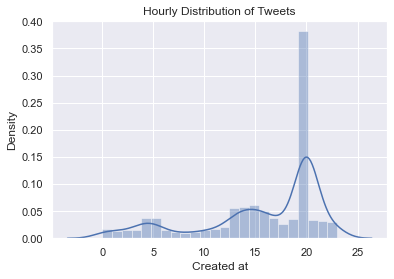

In [4]:
sns.set()

# Plot the histogram of hours
sns.distplot(tweets_processed["Created at"].dt.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

In [5]:
print(tweets_processed["Country"].value_counts())

unknown    4189
US          126
GB           45
IN           28
IL           11
AU           10
NG           10
CA            9
DE            4
IE            4
SG            3
ES            3
FR            3
JP            3
AL            2
KE            2
GE            2
HK            2
BW            2
SO            2
QA            1
NI            1
DO            1
TR            1
JE            1
CH            1
MY            1
NZ            1
JM            1
LK            1
MT            1
Name: Country, dtype: int64


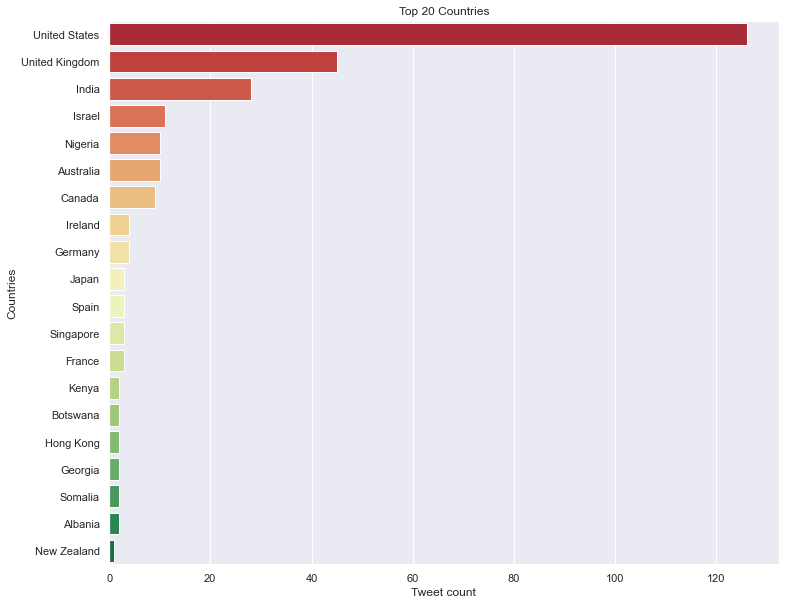

In [6]:
countries = tweets_processed[tweets_processed.Country!='unknown']

# Select the top 20 countries
top_countries = countries["Country"].value_counts(sort=True).head(20)

# Convert alpha2 country codes to country names and store in a list
country_fullnames = []
for alpha2 in top_countries.index:
    country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.barplot(y=country_fullnames,x=top_countries, orient="h", palette="RdYlGn")
plt.xlabel("Tweet count")
plt.ylabel("Countries")
plt.title("Top 20 Countries")
plt.show()

In [7]:
display(tweets_processed.sort_values(by=["Favorites","Retweet-Count", ], axis=0, ascending=False)[["Content","Retweet-Count","Favorites"]].head(20))

,Content,Retweet-Count,Favorites
3516,"When we went to the Amazon warehouse in Bessemer, AL, last week, they didn’t want us to film this video. We need you all to show light on these videos. Everybody in the nation who cares about justice should be standing with the #Bessemer6000. #BAmazonUnion #VOTE #UnionYes https://t.co/TYNKLCdd2a",868,2130
520,#MamtaBanerjee will remember shlokas only in #election time \n#WestBengalElections2021 #WestBengalPolls https://t.co/yAAyzlY2AW,118,401
2397,Civil rights groups have now filed at least 3 legal challenges to Georgia's newly enacted law changing state election procedures. https://t.co/XRWejFvnqp,61,290
2541,Pence lays groundwork for 2024 run https://t.co/orM8eia3Y9 https://t.co/B3VQc2xTAX,47,245
880,". @ScottMorrisonMP Instead of telling us that constituents want to keep MPs they voted for despite the ongoing “unpleasantness”, why not prove it? \n\nCall an election.\n\n#AusPol #ScottyFromDamageControl #ScottyFromMarketing #Election",47,232
970,"As #Election inches closer, desperation of #aiadmk sympathisers is becoming embarrassingly obvious 😀",24,211
1226,Here You go..The Awareness🎗️That have be Done By #SalemSFC 💥 for making People 👥 of Salem to Aware of 100% #Voting in Upcoming #election 🗳️\n\n@Suriya_offl @rajsekarpandian\n@prabhu_sr @2D_ENTPVTLTD\n@TrendsSalem @SalemwomensUnit @TNelectionsCEO https://t.co/AxcZ9wl7OA,125,201
2892,"NEW -- The MyPillow Guy has been having a harder time finding a place to spread Trump's ""Big Lie"" about the election ever since people started getting sued.\n\nLucky for him, he's still got Steve Bannon's show -- which Lindell happens to underwrite.\n\nhttps://t.co/5CR3MoaAmu",52,192
4413,We Can Not Tolerate \nRepublican Bigotry &amp; \nHatefulness Toward People of Color Who Exercise Their Unhindered Constitutional RIGHT To #VOTE.\n\nWe Will NOT Be Silenced.\nThe Filibuster Will Not Stop Us. Pass #HR1 #HR4 \nhttps://t.co/8HNOKEAzJA \n@SenatorWarnock https://t.co/hG6dMf5e6l,85,180
573,"Under a current proposal, pro-democracy groups in Hong Kong could have an even harder time fielding candidates, marking a significant retreat on progress toward full democracy. #HongKong #election \nhttps://t.co/aSYTr8XmLn",173,169


In [10]:
tfidf_stops = ["election","us","president","vote","electrion2020","Democrat", "Repiblican", "rightist", "leftist", "people", "wethepeople","Biden", "Trump","covid", "government"]

# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=15, stop_words= tfidf_stops)

#m = tweets_processed["Processed"].apply(lambda x: ' '.join(x))
# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"].values.astype('U'))

# Let's see what we have
display(tfidf_matrix)

# Create a DataFrame for tf-idf vectors and display the first five rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['biden', 'democrat', 'repiblican', 'trump'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<4471x15 sparse matrix of type '<class 'numpy.float64'>'
	with 5320 stored elements in Compressed Sparse Row format>

,amp,calls,done,gop,governorship,judgment,making,monitor,republicans,review,trump,upcoming,urgently,voting,want
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total frequency'])

# Sort the words by frequency
frequencies.sort_values(by='total frequency',ascending=False, inplace=True)
# Display the most 20 frequent words
display(frequencies.head(20))

,total frequency
amp,502.436836
voting,366.916146
trump,240.378573
want,230.157764
making,181.445142
done,173.484854
upcoming,163.812004
republicans,157.616655
gop,151.902106
calls,150.033558


In [12]:
def remove_floats(row):
  if isinstance(row, str):
    return row
  else:
    return None

for key in tweets_processed:
  tweets_processed["Processed"] =tweets_processed["Processed"] .apply(remove_floats)
tweets_processed.dropna(inplace=True)

m=tweets_processed["Processed"]
tweets_processed["Polarity"] = m.apply(lambda word: TextBlob(word).sentiment.polarity)
tweets_processed["Subjectivity"] = m.apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(tweets_processed[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,0.55,0.95
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.00,0.00
5,0.00,0.00
6,0.00,0.00
7,0.00,0.00
8,0.00,0.00
9,0.00,0.00


In [13]:
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
tweets_processed["Label"] = tweets_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(tweets_processed[["Label"]].head(10))

,Label
0,Positive
1,Neutral
2,Neutral
3,Neutral
4,Neutral
5,Neutral
6,Neutral
7,Neutral
8,Neutral
9,Neutral


In [14]:
print(tweets_processed["Label"].value_counts())

Positive    1829
Neutral     1803
Negative     837
Name: Label, dtype: int64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


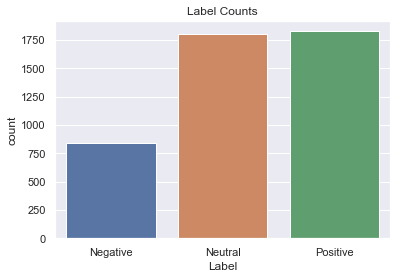

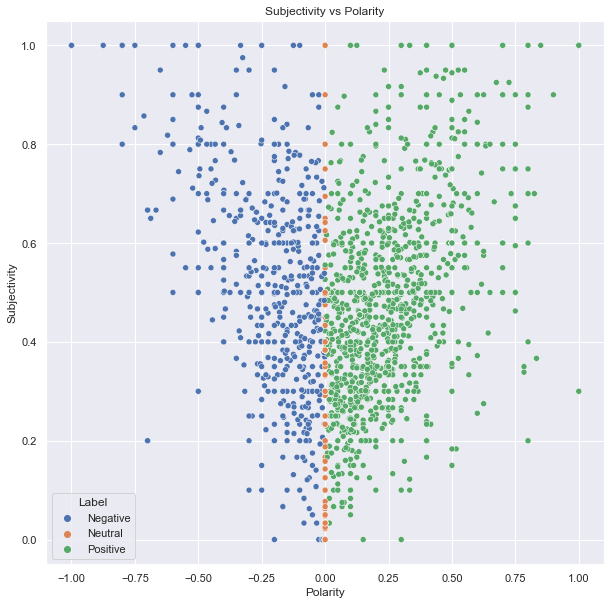

In [15]:
tweets_processed["Label"] = tweets_processed["Label"].astype("category")

# Visualize the Label counts
sns.countplot(tweets_processed["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)
plt.title("Subjectivity vs Polarity")
plt.show()



In [16]:
display(tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
3470,📸 from Shemarfmoore IG story 🗳 #Shemarfmoore #SFM #Journeyofadreamer #HONDO #Swatcbs #SWAT #VOTE for the Best TV show ✴💥🎉💥✴ https://t.co/OJKOZ52CDM,1,10,1.0
3206,Irrespective of the politics I think you have done a superb job @AlisonHernandez and you will have my #vote https://t.co/No00rw08UP,2,8,1.0
4318,#VOTE NOW!!\nYour Choice: Which is the Best Turkish Series of 2020-2021? \n\n#DogdugunEvKaderindir #SenCalKapimi #Hercai #MasumlarApartmanı #Sadakatsiz #MucizeDoktor #Marasli #Masumiyet #Baraj #MenajerimiAra #KırmızıOda #Hanker #EdSer #ZeyMeh #ZeyBar #DicBar \nhttps://t.co/Nqp3JXbCWa,4,7,1.0
3422,Crypto Awards 2021 #VOTE NOW!\nNominee @hitbtc #HitBtc\n#Best #Crypto #Exchange Volume(24h) more 1Billion $\nNomination: #Exchanges\n👉https://t.co/EYB9yoaGu0\n\n#cryptoawards #Bitcoin #cryptocurrency #CryptoNews #altcoins #altcoinnews #CryptocurrencyNews #trading https://t.co/FHncIaNqPu,0,7,1.0
1307,"Today morning our legendary @hasinimani mam and @mookambika_rath mam campaigned for @ikamalhaasan sir, this all about todays morning walkers at Race Course, Coimbatore. #support #election\n\n#kamalhaasan 🔥\n\n#celebrity #legends #suhasini\n#Elections2021 #Chennai https://t.co/jfcbiqYfcB",0,6,1.0
4173,Crypto Awards 2021 #VOTE NOW!\nNominee @dogecoin $dogi\nBest Crypto Coin - MarketCap more 1 Billion $\nNomination: #cryptocurrencies\n👉https://t.co/0MxBaN5SG9\nTake part in the #voting and #chose Best of the #Best\n\n#cryptoawards @cryptunez @elonmusk #Dogecoins @RobinhoodApp #dogearmy https://t.co/iBqiUblIaD,0,6,1.0
1298,"#election view😍🔥🔥🔥\n\nOur legendary suhasini maniratnam ma'am campaigned for @ikamalhaasan sir, in Coimbatore for election. #support #Elections2021 💥\n\n@hasinimani ma'am ♥️\n\n#kamalhaasan\n\n#celebrity #legends #suhasini #evergreen #hasini #suhasinimanirathnam https://t.co/F4RsDEUv0L",0,5,1.0
4355,Which is the Best Turkish Series of 2020-2021? #VOTE FANDOM! 👇😍 #DoğduğunEvKaderindir \n\n#DemetOzdemir #IbrahimCelikkol #EnginOzturk #ZeyMeh #ZeyBar \nhttps://t.co/ISC9MOzrjl,2,4,1.0
4093,"👉 https://t.co/L1kCgz11Cg - choose the best project, company, exchange and person in the industry!\n#VOTE #NOW👍\n\n#cryptoawards #CryptoNews #Bitcoin #best #vote #coin #exchange #coin #Cryptocurrencies #Mining #Investments #Community #media #DeFi #Gaming #gambling #wallets #news https://t.co/YmqUl3HsEy",0,4,1.0
4276,#VOTE NOW!!\nYour Choice: Which is the Best Turkish Series of 2020-2021? \n\n#DemetOzdemir #HandeErcel #HanKer #EdSer #akinakinozu #burakdeniz #ZeyBar #ZeyMeh #KeremBursin #İbrahimCelikkol #FarahZeynepAbdullah #SenCalKapimi #DoğduğunEvKaderindir #Masumiyet\nhttps://t.co/Nqp3JXbCWa,1,3,1.0


,Content,Retweet-Count,Favorites,Polarity
4261,Let’s #vote @Marcus4Georgia to rid the nasty taste of @mtgreenee from our Nation!\n\n#wtpBLUE https://t.co/7CW3CvzQ3F,5,11,-1.000
1582,Douglas Ross was truly awful on that #BBCLeadersDebate. What a disaster for the Conservatives! So who else will lead them after they lose seats in the Holyrood election? 🤔,0,1,-1.000
3362,@NewDay @CNN @AlisynCamerota was a horrible interview of Butch Miller of GA!!! You allowed him to character assassinate Park Cannon and then did not make a distinction between shall and may. Moreover moving ballot boxes inside impacts Americans with Disabilities &amp; more. #vote,0,1,-1.000
1556,"@CNNPolitics I saw a video of him giving a toast at a wedding held at Mar-a-Lago. It was a 5 minute speech about how he was cheated in the election, how the country is doomed, and why Biden is so horrible. A wedding toast. He did at the end toast the couple.",0,0,-1.000
1825,Why Are Republicans Promoting Cruel Election Restrictions? https://t.co/dtu5lso13r,0,0,-1.000
1988,"@jessphillips If only there had been an opportunity to throw them out..\n\nLike an election.\n\nYour buyer's remorse is as pathetic, contemptible &amp; embarrassing as.. \n\nwell.. everything else about you.",0,0,-1.000
2712,@AaronParnas Trying to remove a Democratically elected member of congress is disgusting. Weren't you guys just complaining about Trump trying to do this in the election? #Hypocrisy,0,0,-1.000
3558,This brutal! You all know how to #Vote. Otto #KevinKline is watching you. https://t.co/rN5K7rwxXz https://t.co/bloSEbp6tF,0,1,-0.875
2734,@SUZICLA41809609 @jenminicooper @CANCELtheGOP @laurenboebert Thete has been no proof of democrats doing anything to steal an election! Base your arguments in reality or STFU!,0,1,-0.800
738,Royal scion Pradyot appealed to stop negativity and violent politics in TTAADC elections \n#CPIM #election #negativity #politics #PradyotKishoreManikyaDebBarman #RoyalScion #TIPRA #TTAADC #violent\n#breakingnews #dailynews #currentnews #newsmove\nhttps://t.co/sAZDQgOzxW,0,0,-0.800


Positive 

Country
US    27
GB    11
NG     3
IN     3
IL     3
KE     2
AU     2
TR     1
JM     1
JE     1
IE     1
GE     1
FR     1
DO     1
DE     1
CA     1
Name: Country, dtype: int64

Negative

Country
US    52
GB    17
IN    16
AU     5
NG     4
DE     3
SG     3
IL     2
CA     2
ES     2
JP     2
NZ     1
AL     1
BW     1
CH     1
FR     1
GE     1
IE     1
LK     1
MT     1
NI     1
SO     1
Name: Country, dtype: int64


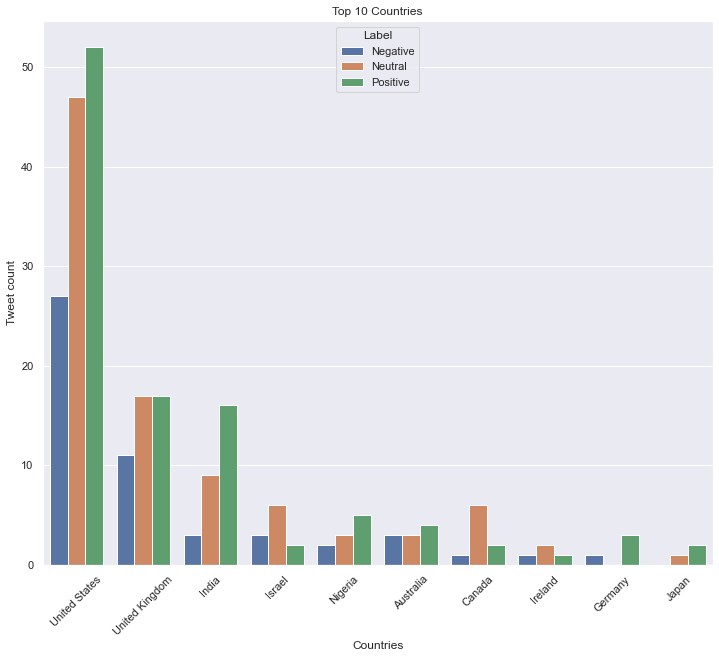

In [17]:
positives_by_country = tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Negative.sort_values(ascending=False)
negatives_by_country =tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Positive.sort_values(ascending=False)

# Print them out
print("Positive \n")
print(positives_by_country)
print("\nNegative\n")
print(negatives_by_country)

# Create a mask for top 1 countries (by tweets count)
mask = tweets_processed["Country"].isin(top_countries.index[:10]).values

# Create a new DataFrame only includes top10 country
top_20df = tweets_processed.iloc[mask,:]

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.countplot(x="Country", hue="Label", data=top_20df, order=top_20df["Country"].value_counts().index)
plt.xlabel("Countries")
locs, labels = plt.xticks()
plt.xticks(locs, country_fullnames[:10])
plt.xticks(rotation=45)
plt.ylabel("Tweet count")
plt.title("Top 10 Countries")
plt.show()

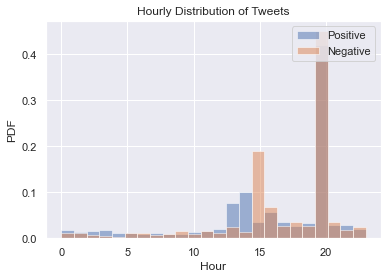

In [18]:
positive = tweets_processed.loc[tweets_processed.Label=="Positive"]["Created at"].dt.hour
negative = tweets_processed.loc[tweets_processed.Label=="Negative"]["Created at"].dt.hour

plt.hist(positive, alpha=0.5, bins=24, label="Positive", density=True)
plt.hist(negative, alpha=0.5, bins=24, label="Negative", density=True)
plt.xlabel("Hour")
plt.ylabel("PDF")
plt.title("Hourly Distribution of Tweets")
plt.legend(loc='upper right')
plt.show()

In [19]:
#Build a model

In [20]:
le = LabelEncoder()
tweets_processed["Label_enc"] = le.fit_transform(tweets_processed["Label"])

# Display the encoded labels
display(tweets_processed[["Label_enc"]].head())

# Select the features and the target
X = tweets_processed['Processed']
y = tweets_processed["Label_enc"]

,Label_enc
0,2
1,1
2,1
3,1
4,1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)



In [22]:
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.6


In [23]:
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[ 54  17  96]
 [ 30 127 204]
 [ 44  26 296]]


Classification Report

              precision    recall  f1-score   support

           0       0.42      0.32      0.37       167
           1       0.75      0.35      0.48       361
           2       0.50      0.81      0.62       366

    accuracy                           0.53       894
   macro avg       0.56      0.49      0.49       894
weighted avg       0.58      0.53      0.51       894



In [25]:
pickle.dump(nb, open("election_model.pkl", 'wb'))

In [26]:
tweets_processed.to_csv("election_sentiments.csv")